In [1]:
from google.colab import drive
drive.mount('/content/drive')
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import os
from IPython.display import clear_output
import numpy as np

import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
import torchvision.models as models
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt

Mounted at /content/drive


In [2]:


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Обучение

In [ ]:
!pip install wandb -qU
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
class CIFAR10Dataset(Dataset):
    def __init__(self, root, train=True, download=True):
      if train:
        transform = T.Compose([
          T.Resize(256),
          T.RandomHorizontalFlip(),
          T.ToTensor(),
          T.Normalize(mean=[0.485, 0.456, 0.486], std=[0.229 , 0.224, 0.225]),
        ]) 
      else:
          transform = T.Compose([
              T.Resize(256),
              T.ToTensor(),
              T.Normalize(mean=[0.485, 0.456, 0.486], std=[0.229 , 0.224, 0.225]),
        ]) 
      self.tv_dataset = CIFAR10(
            root, 
            train=train,
            download=download,
            transform=transform,
        )

    def __len__(self):
        return len(self.tv_dataset)

    def __getitem__(self, ix):
        return self.tv_dataset[ix]


In [ ]:
def prune_net(net, prune_ratio=0.3, method="l1"):
    parameters_to_prune = [
        (module, "weight") for module in filter(lambda m: type(m) == torch.nn.Conv2d, net.modules())
    ]
    
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=prune_ratio,
    )

def copy_weights_layer(layer_unpruned, layer_pruned):
    with torch.no_grad():
      if "weight" in layer_pruned.state_dict():
        layer_pruned.weight.copy_(layer_unpruned.weight)
      if "weight_orig" in layer_pruned.state_dict():
        layer_pruned.weight_orig.copy_(layer_unpruned.weight)
      if "bias" in layer_pruned.state_dict():
        layer_pruned.bias.copy_(layer_unpruned.bias)
      if "running_mean" in layer_pruned.state_dict():
        layer_pruned.running_mean.copy_(layer_unpruned.running_mean)
      if "running_var" in layer_pruned.state_dict():
        layer_pruned.running_var.copy_(layer_unpruned.running_var)

def copy_weights_net(net_unpruned, net_pruned):
    zipped = zip(net_unpruned.modules(), net_pruned.modules())

    for layer_unpruned, layer_pruned in zipped:
      if "weight" in layer_unpruned.state_dict():
        copy_weights_layer(layer_unpruned, layer_pruned)


In [ ]:
def loop_dataloader(dataloader):
    while True:
        for x in iter(dataloader):
            yield x


def train(model, dataloader_train, loss_inst, optimizer, max_iter=10_000,
          dataloader_val=None, val_freq=500, scheduler=None):
    global device
    iterable = loop_dataloader(dataloader_train)
    iterable = tqdm.tqdm(iterable, total=max_iter)
    it = 0
    for X_batch, y_batch in iterable:
        if it == max_iter:
            break
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logit_batch = model(X_batch)

        loss = loss_inst(logit_batch, y_batch)
        if dataloader_val is not None:
            wandb.log({"loss": loss}, step=it)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
          scheduler.step()

        if it % val_freq == 0 and dataloader_val is not None:
            model.eval()
            is_equal = []

            for X_batch_val, y_batch_val in dataloader_val:
                X_batch_val = X_batch_val.to(device)
                y_batch_val = y_batch_val.to(device)
                is_equal.append(
                    model(X_batch_val).argmax(dim=-1) == y_batch_val
                )

            is_equal_t = torch.cat(is_equal)
            acc = is_equal_t.sum() / len(is_equal_t)
            wandb.log({"accuracy_val": acc}, step=it)
            model.train()

        it += 1
        
def experiment(MAX_ITER, PRUNE_ITER, PRUNE_RATIO , RANDOM_STATE, SCHEDULE, LR, project_name):
    args = {"max-iter" : 30000, "batch-size" : 64, "prune-iter" : 1, "prune-ratio" : 0.2, "prune-method" : "l1", "val-freq" : 250, "random-state" : 1}
    
    
    # os.mkdir("/content/drive/MyDrive/torch.resnet18+cifar10/pr" + str(PRUNE_RATIO) + "_sched" + str(int(SCHEDULE)) + "_lr" + str(LR))
    

    args["max-iter"] = MAX_ITER
    args["prune-iter"] = PRUNE_ITER
    args["prune-ratio"] = PRUNE_RATIO
    args["random-state"] = RANDOM_STATE

    wandb.init(
        project=project_name,
        entity="bspanfilov",
        config=args,
    )
    wandb.define_metric("accuracy_val", summary="max")

    dataset_train = CIFAR10Dataset(
        "data",
        train=True,
        download=True,
    )
    dataset_val = CIFAR10Dataset(
        "data",
        train=False,
        download=True,
    )

    if args["random-state"] is not None:
        torch.manual_seed(args["random-state"])

    dataloader_train = DataLoader(
        dataset_train, batch_size=args["batch-size"], shuffle=True
    )
    dataloader_val = DataLoader(
        dataset_val, batch_size=args["batch-size"], shuffle=True
    )

    kwargs = dict(
        num_classes=10,
    )

    # net = models.resnet18(**kwargs).to(device)
    net = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0.96_sched0_lr0.03/prune_it4").to(device)
    net_copy = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0.96_sched0_lr0.03/base").to(device)
    # net_copy = models.resnet18(**kwargs).to(device)
    # net_copy.load_state_dict(net.state_dict())

    # torch.save(net_copy, "/content/drive/MyDrive/torch.resnet18+cifar10/pr" + str(PRUNE_RATIO) + "_sched" + str(int(SCHEDULE)) + "_lr" + str(LR) + "/base")

    loss_inst = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=LR, momentum=0.9)
    if SCHEDULE:
      scheduler = MultiStepLR(optimizer, milestones=[20000,25000], gamma=0.1)
    else:
      scheduler = None

    per_round_prune_ratio = 1 - (1 - args["prune-ratio"]) ** (1 / args["prune-iter"])
    prune_net(net, per_round_prune_ratio)
    copy_weights_net(net_copy, net)

    # if args["prune-ratio"] > 0:
    #     per_round_prune_ratio = 1 - (1 - args["prune-ratio"]) ** (1 / args["prune-iter"])

    #     per_round_max_iter = int(args["max-iter"] / args["prune-iter"])

    #     for prune_it in range(args["prune-iter"]):
    #         train(
    #             net,
    #             dataloader_train,
    #             loss_inst,
    #             optimizer,
    #             max_iter=per_round_max_iter,
    #         )

    #         torch.save(net, "/content/drive/MyDrive/torch.resnet18+cifar10/pr" + str(PRUNE_RATIO) + "_sched" + str(int(SCHEDULE)) + "_lr" + str(LR) + "/prune_it" + str(prune_it))

    #         prune_net(net, per_round_prune_ratio)
    #         copy_weights_net(net_copy, net)

    # Run actual training with a final pruned network
    train(
        net,
        dataloader_train,
        loss_inst,
        optimizer,
        max_iter=args["max-iter"],
        dataloader_val=dataloader_val,
        val_freq=args["val-freq"],
        scheduler=scheduler,
    )

    torch.save(net, "/content/drive/MyDrive/torch.resnet18+cifar10/pr" + str(PRUNE_RATIO) + "_sched" + str(int(SCHEDULE)) + "_lr" + str(LR) + "/pruned")



In [ ]:
# тут просто настройки, с которыми я как раз запускал эксперименты
MAX_ITERS=[10000]
PRUNE_ITERS=[5]
PRUNE_RATIOS=[0.96]
RANDOM_STATES=[2] 
SCHEDULE = [False]
LR = [0.03]
for p in zip(MAX_ITERS, PRUNE_ITERS, PRUNE_RATIOS, RANDOM_STATES, SCHEDULE, LR):
  experiment(p[0], p[1], p[2], p[3], p[4], p[5], "cifar10 + torch.resnet18")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


100%|██████████| 170498071/170498071 [00:03<00:00, 45807299.08it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


100%|██████████| 10000/10000 [53:31<00:00,  3.11it/s]


In [ ]:
def loop_dataloader(dataloader):
    while True:
        for x in iter(dataloader):
            yield x


def train(model, dataloader_train, loss_inst, optimizer, max_iter=10_000,
          dataloader_val=None, val_freq=500, scheduler=None):
    global device
    iterable = loop_dataloader(dataloader_train)
    iterable = tqdm.tqdm(iterable, total=max_iter)
    it = 0
    for X_batch, y_batch in iterable:
        if it == max_iter:
            break
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logit_batch = model(X_batch)

        loss = loss_inst(logit_batch, y_batch)
        if dataloader_val is not None:
            wandb.log({"loss": loss}, step=it)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
          scheduler.step()

        if it % val_freq == 0 and dataloader_val is not None:
            model.eval()
            is_equal = []

            for X_batch_val, y_batch_val in dataloader_val:
                X_batch_val = X_batch_val.to(device)
                y_batch_val = y_batch_val.to(device)
                is_equal.append(
                    model(X_batch_val).argmax(dim=-1) == y_batch_val
                )

            is_equal_t = torch.cat(is_equal)
            acc = is_equal_t.sum() / len(is_equal_t)
            wandb.log({"accuracy_val": acc}, step=it)
            model.train()

        it += 1
        
def experiment(MAX_ITER, PRUNE_ITER, PRUNE_RATIO , RANDOM_STATE, SCHEDULE, LR, project_name):
    args = {"max-iter" : 30000, "batch-size" : 64, "prune-iter" : 1, "prune-ratio" : 0.2, "prune-method" : "l1", "val-freq" : 250, "random-state" : 1}
    
    
    os.mkdir("/content/drive/MyDrive/torch.resnet18+cifar10/pr" + str(PRUNE_RATIO) + "_sched" + str(int(SCHEDULE)) + "_lr" + str(LR))
    

    args["max-iter"] = MAX_ITER
    args["prune-iter"] = PRUNE_ITER
    args["prune-ratio"] = PRUNE_RATIO
    args["random-state"] = RANDOM_STATE

    wandb.init(
        project=project_name,
        entity="bspanfilov",
        config=args,
    )
    wandb.define_metric("accuracy_val", summary="max")

    dataset_train = CIFAR10Dataset(
        "data",
        train=True,
        download=True,
    )
    dataset_val = CIFAR10Dataset(
        "data",
        train=False,
        download=True,
    )

    if args["random-state"] is not None:
        torch.manual_seed(args["random-state"])

    dataloader_train = DataLoader(
        dataset_train, batch_size=args["batch-size"], shuffle=True
    )
    dataloader_val = DataLoader(
        dataset_val, batch_size=args["batch-size"], shuffle=True
    )

    kwargs = dict(
        num_classes=10,
    )

    net = models.resnet18(**kwargs).to(device)

    net_copy = models.resnet18(**kwargs).to(device)
    net_copy.load_state_dict(net.state_dict())

    torch.save(net_copy, "/content/drive/MyDrive/torch.resnet18+cifar10/pr" + str(PRUNE_RATIO) + "_sched" + str(int(SCHEDULE)) + "_lr" + str(LR) + "/base")

    loss_inst = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=LR, momentum=0.9)
    if SCHEDULE:
      scheduler = MultiStepLR(optimizer, milestones=[6000,8000], gamma=0.1)
    else:
      scheduler = None

    if args["prune-ratio"] > 0:
        per_round_prune_ratio = 1 - (1 - args["prune-ratio"]) ** (1 / args["prune-iter"])

        per_round_max_iter = int(args["max-iter"] / args["prune-iter"])

        for prune_it in range(args["prune-iter"]):
            train(
                net,
                dataloader_train,
                loss_inst,
                optimizer,
                max_iter=per_round_max_iter,
            )

            torch.save(net, "/content/drive/MyDrive/torch.resnet18+cifar10/pr" + str(PRUNE_RATIO) + "_sched" + str(int(SCHEDULE)) + "_lr" + str(LR) + "/prune_it" + str(prune_it))

            prune_net(net, per_round_prune_ratio)
            copy_weights_net(net_copy, net)

    # Run actual training with a final pruned network
    train(
        net,
        dataloader_train,
        loss_inst,
        optimizer,
        max_iter=args["max-iter"],
        dataloader_val=dataloader_val,
        val_freq=args["val-freq"],
        scheduler=scheduler,
    )

    torch.save(net, "/content/drive/MyDrive/torch.resnet18+cifar10/pr" + str(PRUNE_RATIO) + "_sched" + str(int(SCHEDULE)) + "_lr" + str(LR) + "/pruned")



In [ ]:
# тут просто настройки, с которыми я как раз запускал эксперименты
MAX_ITERS=[10000]
PRUNE_ITERS=[5]
PRUNE_RATIOS=[0.96]
RANDOM_STATES=[2] 
SCHEDULE = [True]
LR = [0.03]
for p in zip(MAX_ITERS, PRUNE_ITERS, PRUNE_RATIOS, RANDOM_STATES, SCHEDULE, LR):
  experiment(p[0], p[1], p[2], p[3], p[4], p[5], "cifar10 + torch.resnet18")

accuracy_val,▁▆▇█▇▇██████████████████████████████████
loss,█▆▅▇▃▃▃▂▂▃▃▄▃▃▂▂▂▂▂▂▃▂▂▂▂▁▂▂▂▁▃▂▂▂▁▃▁▁▂▁
loss,0.06188


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10000/10000 [53:25<00:00,  3.12it/s]


## Интерполояция


In [4]:
transform = T.Compose([
    T.Resize(256),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.486], std=[0.229 , 0.224, 0.225]),
]) 

test_set = CIFAR10(root='./data', transform=transform, train=False, download=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:05<00:00, 29496484.79it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
def make_inter_layer(alpha, first, second, ans_layer):
  with torch.no_grad():
      if "weight" in first.state_dict():
        ans_layer.weight.copy_(alpha * first.weight)
      if "weight_orig" in first.state_dict():
        ans_layer.weight.copy_(alpha * (first.weight_orig * first.weight_mask))
    
      if "weight" in second.state_dict():
        ans_layer.weight += (1. - alpha) * second.weight
      if "weight_orig" in second.state_dict():
        ans_layer.weight += (1. - alpha) * (second.weight_orig * second.weight_mask)

      if "bias" in ans_layer.state_dict():
        ans_layer.bias.copy_(alpha * first.bias + (1. - alpha) * second.bias)
      if "running_mean" in ans_layer.state_dict():
        ans_layer.running_mean.copy_(alpha * first.running_mean + (1. - alpha) * second.running_mean)
      if "running_var" in ans_layer.state_dict():
        ans_layer.running_var.copy_(alpha * first.running_var + (1. - alpha) * second.running_var)

def interpolation(alpha: float, first: models.resnet18, second: models.resnet18) ->  models.resnet18:
  kwargs = dict(
      num_classes=10,
  )

  ans = models.resnet18(**kwargs).to(device)

  zipped = zip(first.modules(), second.modules(), ans.modules())

  for layer_first, layer_second, layer_ans in zipped:
    if "weight" in layer_ans.state_dict():
      make_inter_layer(alpha, layer_first, layer_second, layer_ans)

  return ans

def loss_calculation(net) -> list[float]:
    loss_inst = nn.CrossEntropyLoss()
    test_loss, test_accuracy = 0.0, 0.0
    net.eval()
    for X_batch, y_batch in tqdm(test_loader, desc='testing'):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      with torch.no_grad():
        logits = net(X_batch)
        loss = loss_inst(logits, y_batch)
      
      test_loss += loss.item() * X_batch.shape[0]
      test_accuracy += (logits.argmax(dim=1) == y_batch).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

def get_losses(ndots, first, second):
  x = np.linspace(0, 1, ndots)
  res = []
  for i, num in enumerate(x):
    with torch.no_grad():
      inter = interpolation(num, first, second).to(device)
    print(i)
    res.append((num, loss_calculation(inter)[0]))
    clear_output()
  return res

def plot_losses(num_of_graphs, los_for_plot):
  fig, axs = plt.subplots(1, num_of_graphs, figsize=(30, 5))
  
  for i in range(num_of_graphs):
    x = [p for p, j in los_for_plot[i]]
    y = [j for p, j in los_for_plot[i]]
    axs[i].plot(x, y, color="red", label="line")
    if (i < num_of_graphs - 2):
      axs[i].set(title="prune_it" + str(i + 1))
    else:
      axs[-1].set(title="pruned")
  plt.show()

### Сравнение моделей с той, которую вообще не обрезал. 

Вообще даже по графикам видно что необрезанная попала в другую базину нежели все. Просто хотелось удостоверится в этом

#### pr=0.93 sched=0 lr=0.03

In [ ]:
base = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0_sched0_lr0.03/pruned").to(device)
directory = "/content/drive/MyDrive/torch.resnet18+cifar10/pr0.93_sched0_lr0.03"
los_for_plot = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        model = torch.load(f).to(device)
        los_for_plot.append(get_losses(10, base, model))

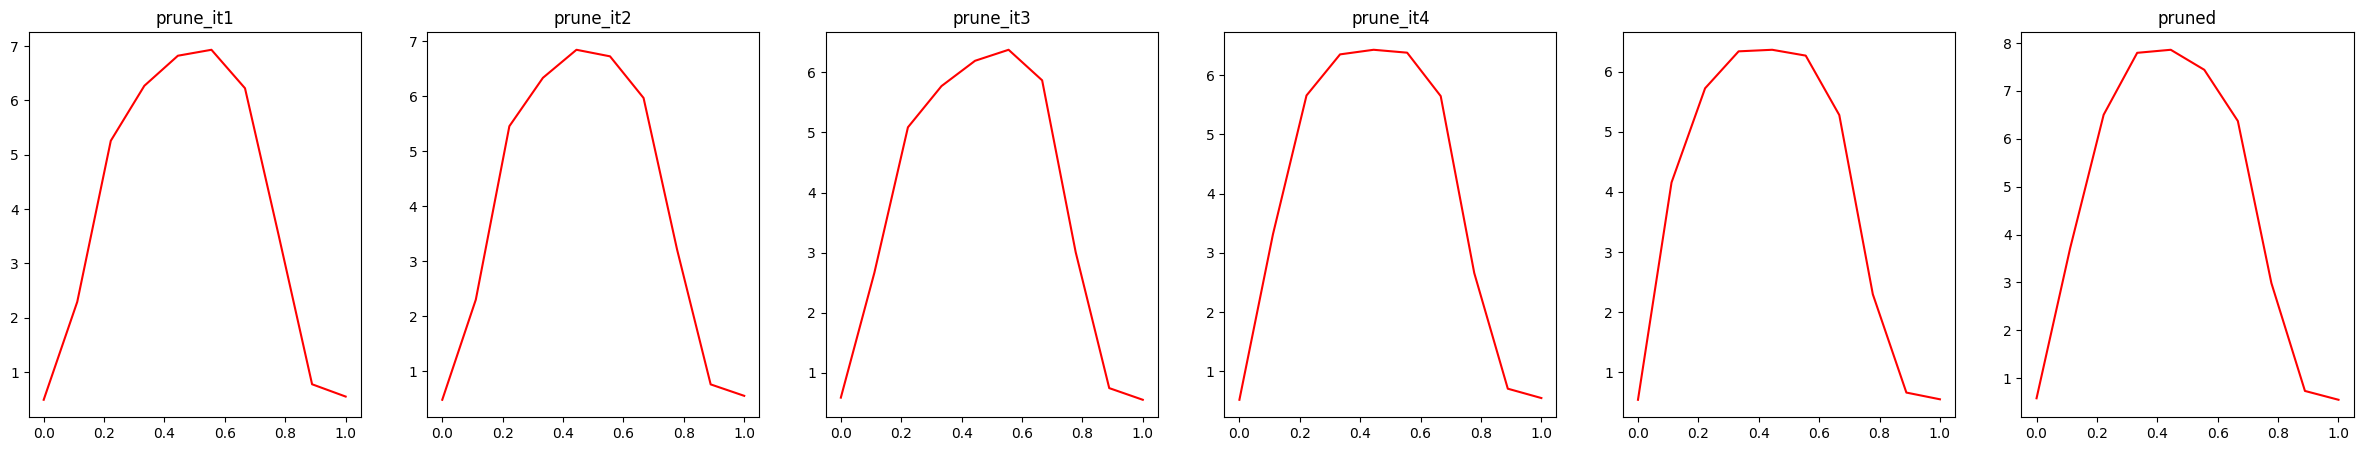

In [ ]:
plot_losses(los_for_plot)

#### pr=0.93 sched=1 lr=0.03

In [ ]:
base = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0_sched0_lr0.03/pruned").to(device)
directory = "/content/drive/MyDrive/torch.resnet18+cifar10/pr0.93_sched1_lr0.03"
los_for_plot = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        model = torch.load(f).to(device)
        los_for_plot.append(get_losses(10, base, model))

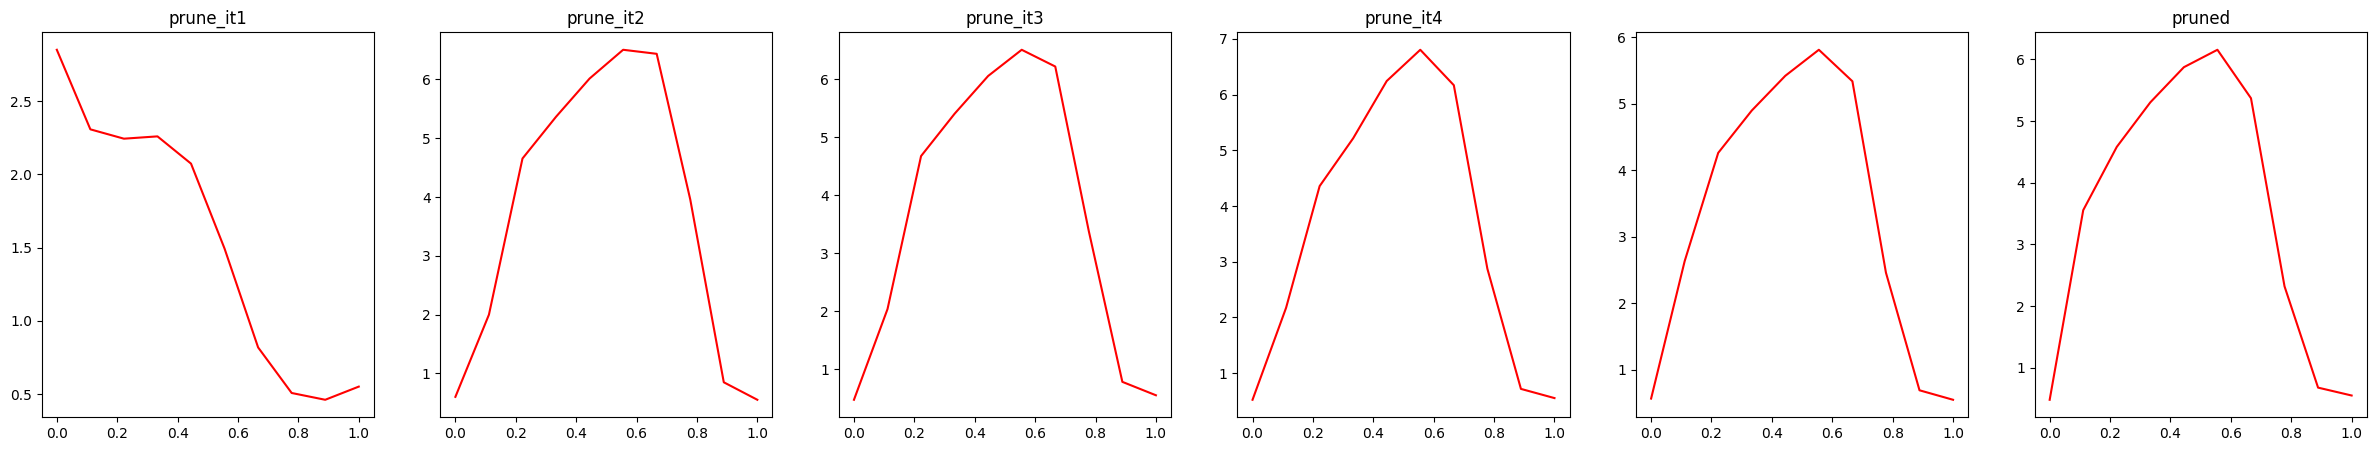

In [ ]:
plot_losses(los_for_plot)
# первый график отличается, потому что я забыл убрать
#  из рассмотрения модель с которой начинал обучение

#### pr=0.96 sched=0 lr=0.03

In [ ]:
base = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0_sched0_lr0.03/pruned").to(device)
directory = "/content/drive/MyDrive/torch.resnet18+cifar10/pr0.96_sched0_lr0.03"
los_for_plot = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        model = torch.load(f).to(device)
        los_for_plot.append(get_losses(10, base, model))

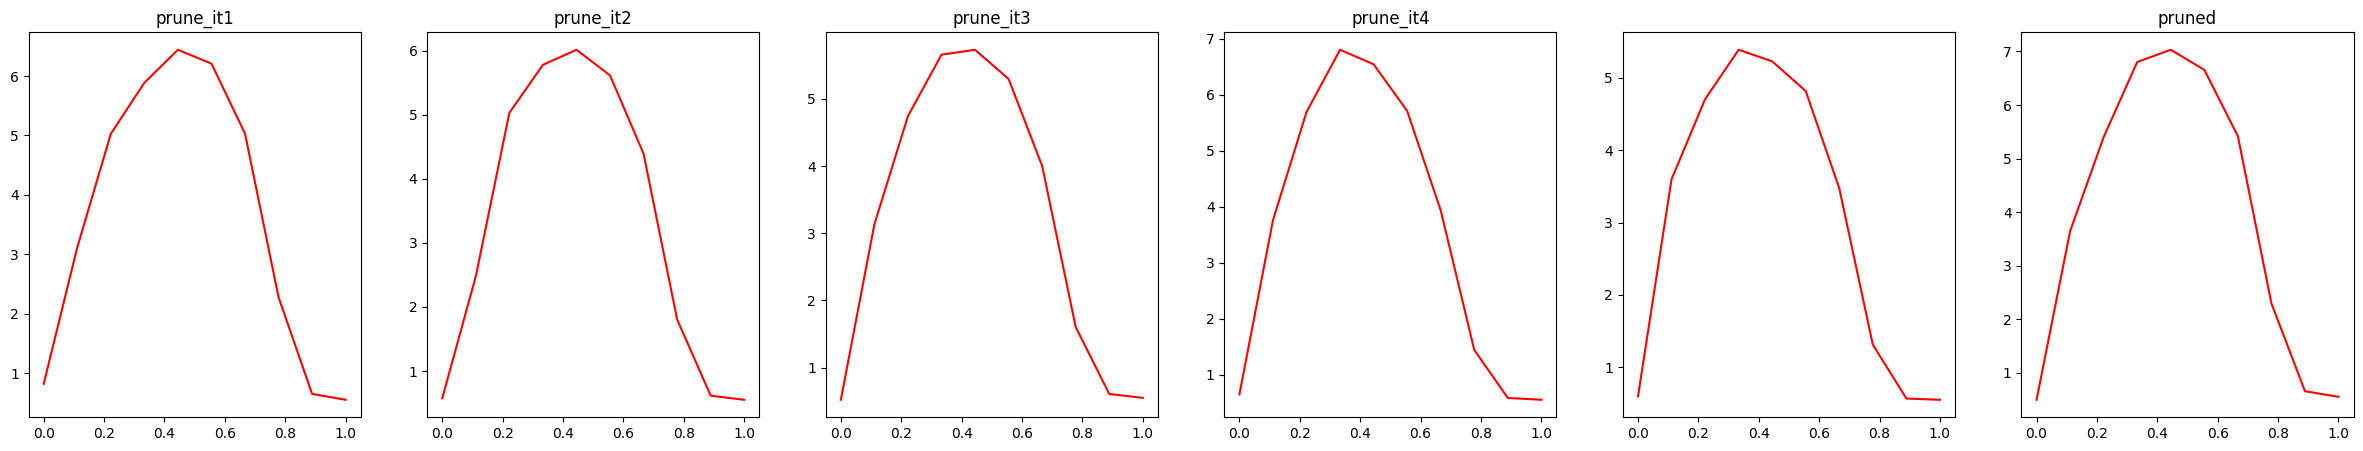

In [ ]:
plot_losses(los_for_plot[1:])

#### pr=0.96 sched=1 lr=0.03

In [ ]:
base = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0_sched0_lr0.03/pruned").to(device)
directory = "/content/drive/MyDrive/torch.resnet18+cifar10/pr0.96_sched1_lr0.03"
los_for_plot = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        model = torch.load(f).to(device)
        los_for_plot.append(get_losses(10, base, model))

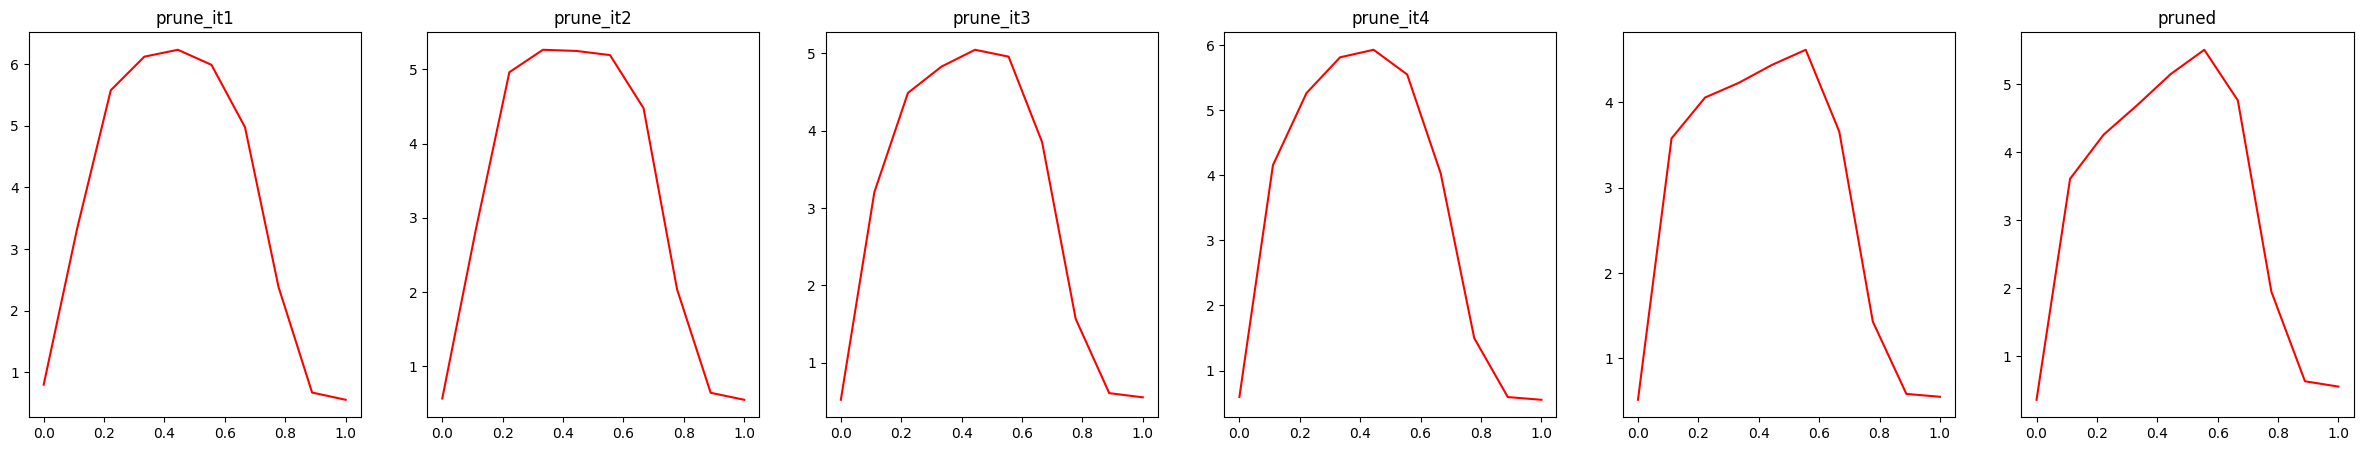

In [ ]:
plot_losses(los_for_plot[1:])

в общем то предположение оправдалось

### Сравнение моделей обрезанных окончательно и начальных с промежуточными результатами

#### pr0.93_sched0_lr0.03

In [ ]:
pruned = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0.93_sched0_lr0.03/pruned").to(device)
directory = "/content/drive/MyDrive/torch.resnet18+cifar10/pr0.93_sched0_lr0.03"
los_for_plot = []
for i, filename in enumerate(os.listdir(directory)):
    if i == 5:
      break
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        model = torch.load(f).to(device)
        los_for_plot.append(get_losses(10, pruned, model))

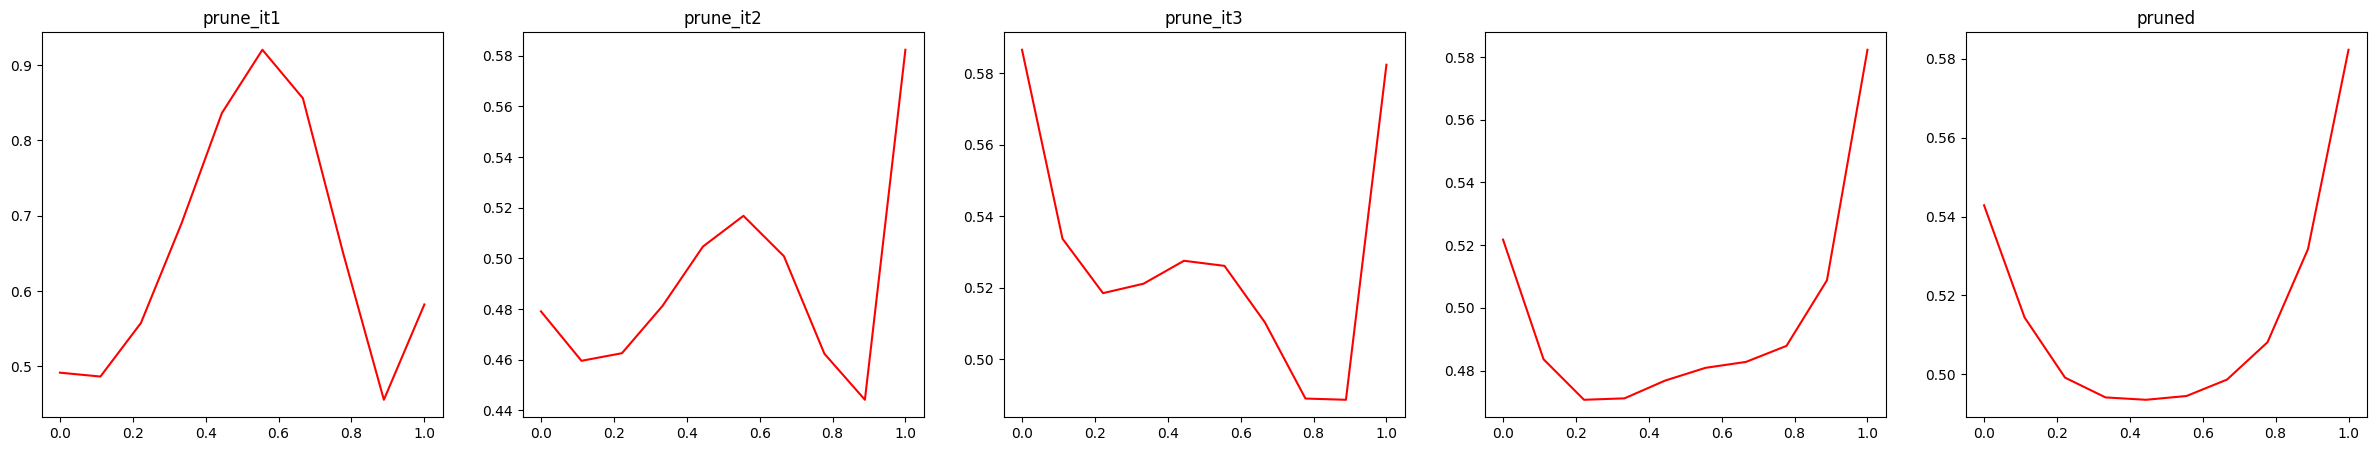

In [ ]:
plot_losses(5, los_for_plot)
# на самом деле тут 5 разных итераций

#### pr0.93_sched1_lr0.03

In [ ]:
pruned = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0.93_sched1_lr0.03/pruned").to(device)
directory = "/content/drive/MyDrive/torch.resnet18+cifar10/pr0.93_sched1_lr0.03"
los_for_plot = []
for i, filename in enumerate(os.listdir(directory)):
    if i == 0:
      continue
    if i == 6:
      break
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        model = torch.load(f).to(device)
        los_for_plot.append(get_losses(10, pruned, model))

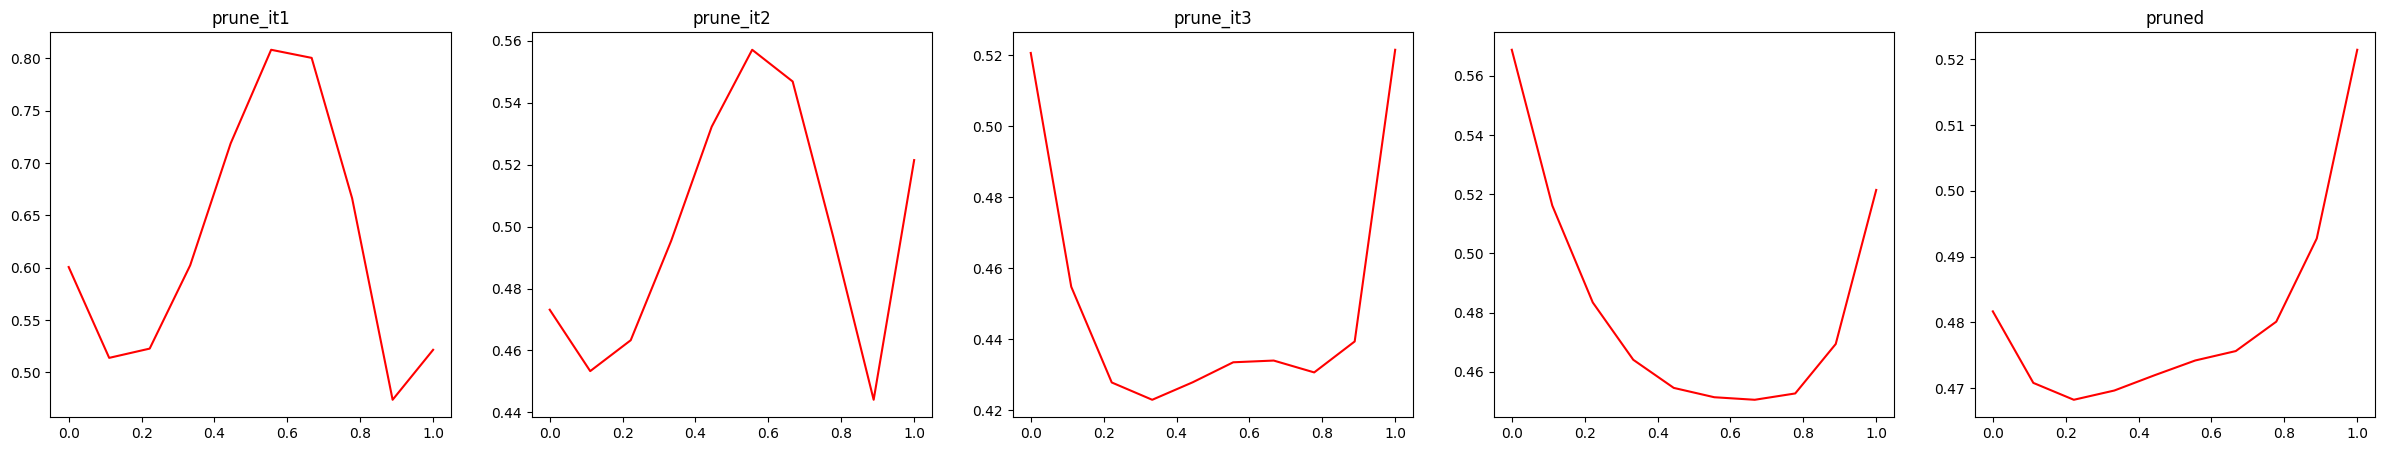

In [ ]:
plot_losses(5, los_for_plot)
# получается, что со второй итерации прунинга мы улетели в другую базину

In [ ]:
base = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0.93_sched1_lr0.03/base").to(device)
directory = "/content/drive/MyDrive/torch.resnet18+cifar10/pr0.93_sched1_lr0.03"
los_for_plot = []
for i, filename in enumerate(os.listdir(directory)):
    if i == 0:
      continue
    if i == 6:
      break
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        model = torch.load(f).to(device)
        los_for_plot.append(get_losses(10, base, model))

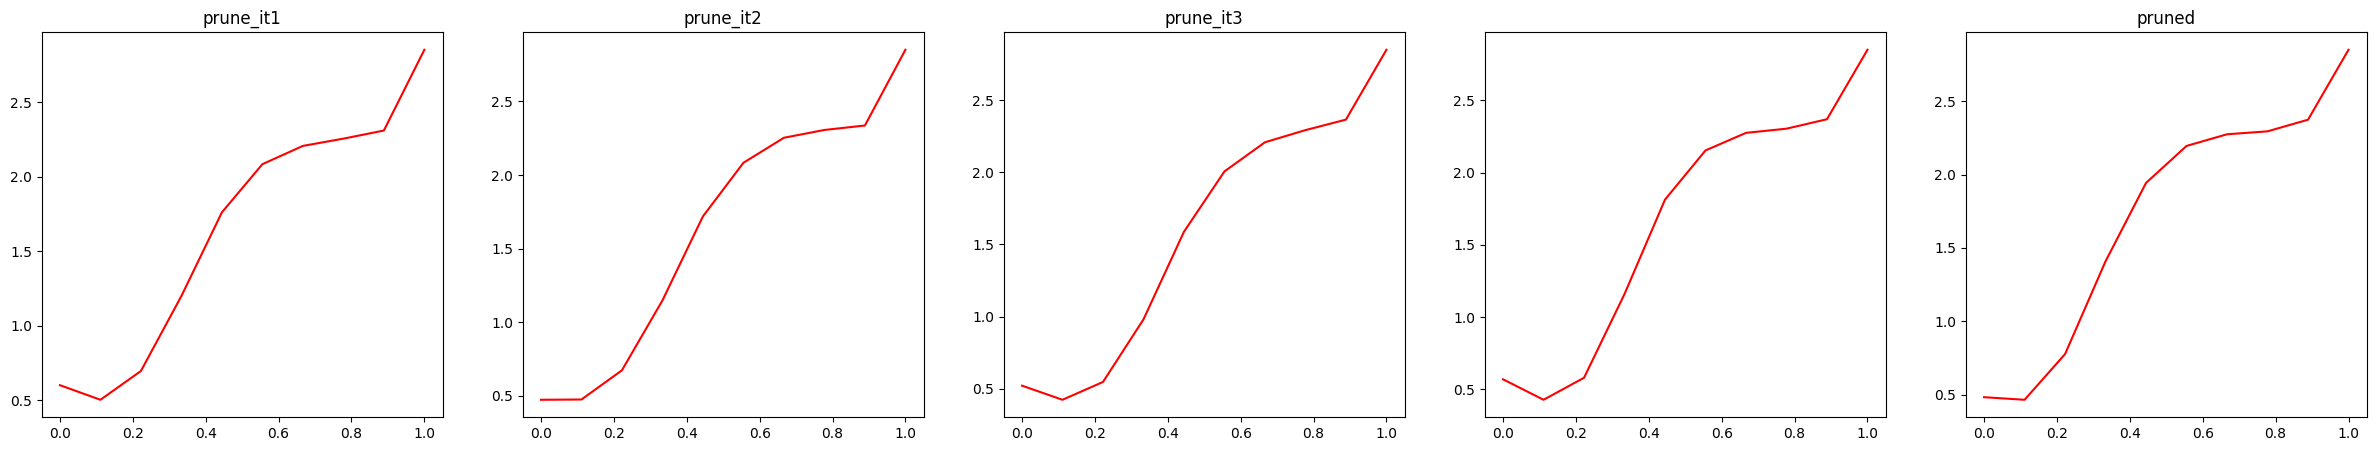

In [ ]:
plot_losses(5, los_for_plot)
# думал, что вдруг они уходят за какой-то бугор лосса, но вроде нет
# непонятно тогда откуда такая большая ошибка(бугор) между моделью без обрезки
# и обрезанными моделями

#### pr0.96_sched0_lr0.03

In [ ]:
pruned = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0.96_sched0_lr0.03/pruned").to(device)
directory = "/content/drive/MyDrive/torch.resnet18+cifar10/pr0.96_sched0_lr0.03"
los_for_plot = []
for i, filename in enumerate(os.listdir(directory)):
    if i == 0:
      continue
    if i == 6:
      break
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        model = torch.load(f).to(device)
        los_for_plot.append(get_losses(10, pruned, model))

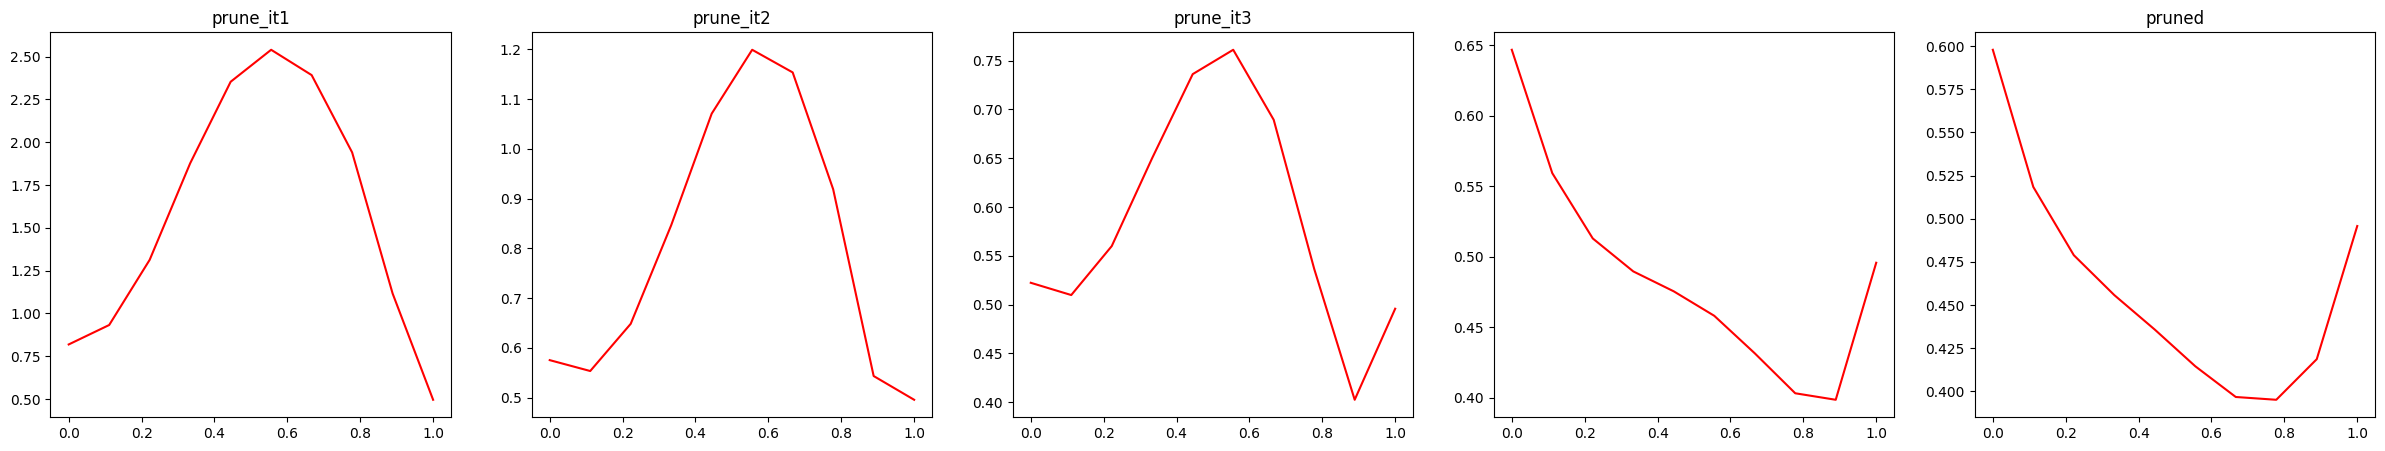

In [ ]:
plot_losses(5, los_for_plot)

In [ ]:
base = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0.96_sched0_lr0.03/base").to(device)
directory = "/content/drive/MyDrive/torch.resnet18+cifar10/pr0.96_sched0_lr0.03"
los_for_plot = []
for i, filename in enumerate(os.listdir(directory)):
    if i == 0:
      continue
    if i == 6:
      break
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        model = torch.load(f).to(device)
        los_for_plot.append(get_losses(10, base, model))

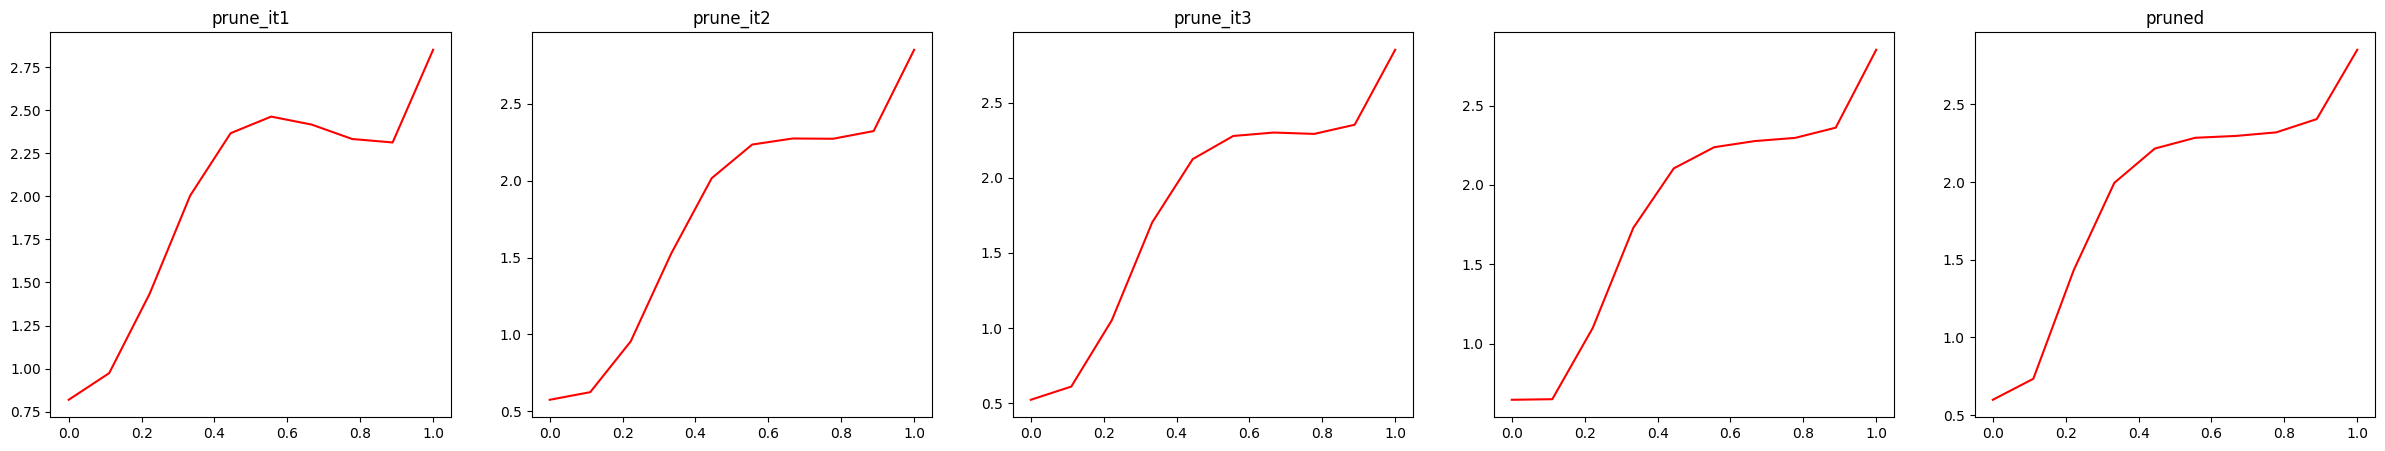

In [ ]:
plot_losses(5, los_for_plot)

#### pr0.96_sched1_lr0.03

In [ ]:
pruned = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0.96_sched1_lr0.03/pruned").to(device)
directory = "/content/drive/MyDrive/torch.resnet18+cifar10/pr0.96_sched1_lr0.03"
los_for_plot = []
for i, filename in enumerate(os.listdir(directory)):
    if i == 0:
      continue
    if i == 6:
      break
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        model = torch.load(f).to(device)
        los_for_plot.append(get_losses(10, pruned, model))

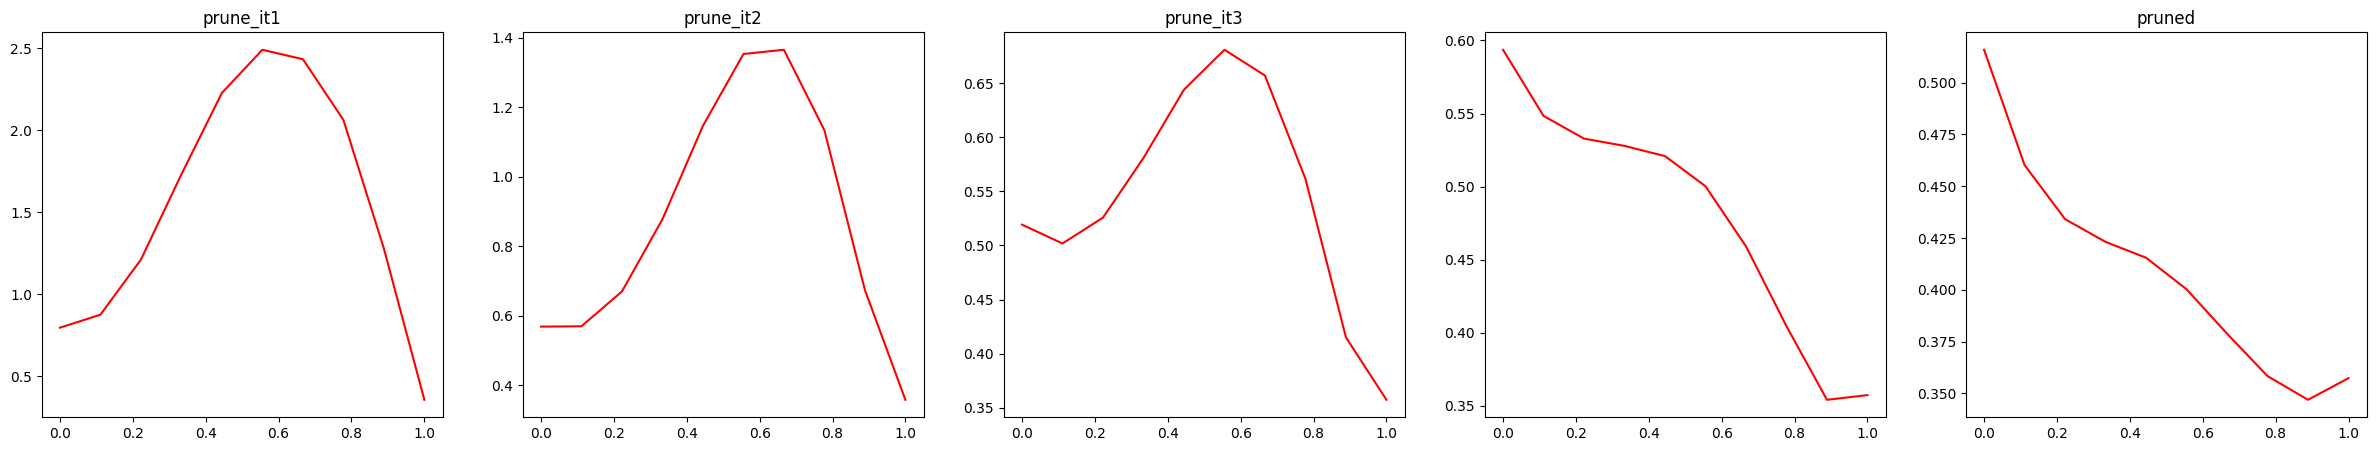

In [ ]:
plot_losses(5, los_for_plot)

In [ ]:
base = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0.96_sched1_lr0.03/base").to(device)
directory = "/content/drive/MyDrive/torch.resnet18+cifar10/pr0.96_sched1_lr0.03"
los_for_plot = []
for i, filename in enumerate(os.listdir(directory)):
    if i == 0:
      continue
    if i == 6:
      break
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        model = torch.load(f).to(device)
        los_for_plot.append(get_losses(10, base, model))

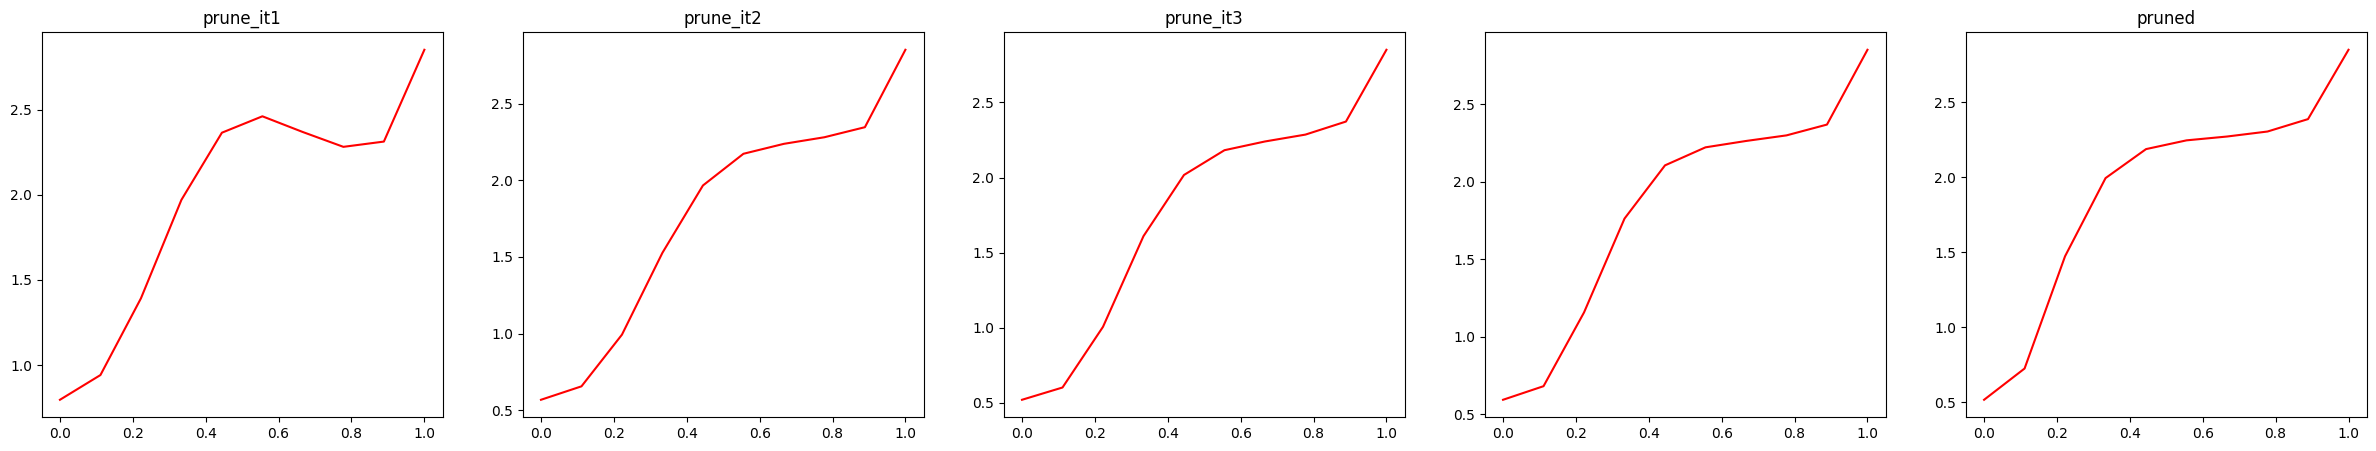

In [ ]:
plot_losses(5, los_for_plot)

### Захотелось сравнить модели с pr=0.96, потому что у модели с шедулером на графике явно виден скачок в какое-то более удачное место в базине после итерации шедулера на 6000

In [ ]:
sched = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0.96_sched1_lr0.03/pruned")
simple = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0.96_sched0_lr0.03/pruned")

losses = get_losses(10, sched, simple)

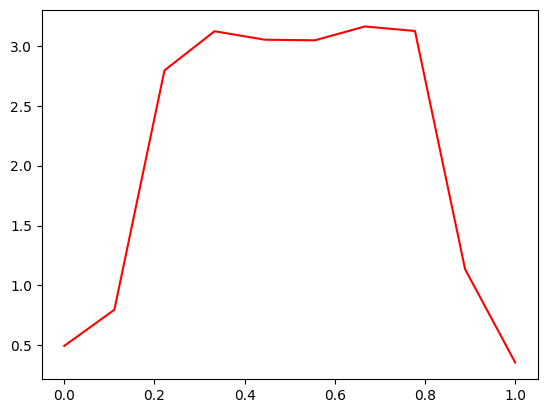

In [ ]:
x = [i for i, j in losses]
y = [j for i, j in losses]
plt.plot(x, y, color="red")

Афигеть, шедулер реально помог попась в другую базину, что помогло ей лучше обучиться. Вот это считаю прикольным результатом

### У моделей с pr=0.93 такого заметно скачка незаметно, но сравнить их все равно инересно

In [6]:
sched = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0.93_sched1_lr0.03/pruned")
simple = torch.load("/content/drive/MyDrive/torch.resnet18+cifar10/pr0.93_sched0_lr0.03/pruned")

losses = get_losses(10, sched, simple)

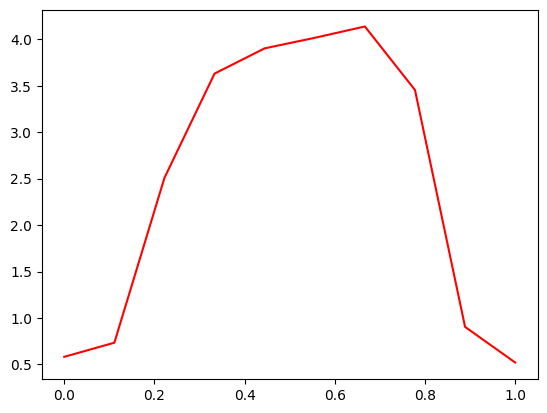

In [7]:
x = [i for i, j in losses]
y = [j for i, j in losses]
plt.plot(x, y, color="red")

Удивительно, но тут шедулер тоже помог свалиться модели в другую базину, хотя на графиках обучения это не так заметно. Да и на скор это не сильно повлияло

